### imports 

In [2]:
import os
from os import path
import configparser
from github import Github
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timezone
import requests
from requests.adapters import HTTPAdapter, Retry

In [3]:
import githubanalysis.processing.repo_name_clean as name_clean
import githubanalysis.processing.get_repo_connection as ghconnect
import githubanalysis.processing.setup_github_auth as ghauth
import githubanalysis.processing.get_all_pages_issues as getallissues
import githubanalysis.analysis.calc_days_since_repo_creation as dayssince
import githubanalysis.processing.summarise_repo_stats
from githubanalysis.processing.summarise_repo_stats import RepoStatsSummariser
import utilities.get_default_logger as loggit
import utilities.chunker as chunker

### access token 

In [4]:
# set up github access token with github package: 

config = configparser.ConfigParser()
config.read('../config.cfg')
config.sections()

access_token = config['ACCESS']['token']
g = Github(access_token) 

gh_token = ghauth.setup_github_auth(config_path='../../githubanalysis/config.cfg')
headers = {f"Authorization: Bearer {gh_token}"}

### Load repo stats file

In [8]:
total_stats = pd.read_csv("../../data/gh_stats_2024-02-08_eidf.csv", header=0)
print(total_stats.head)

<bound method NDFrame.head of                                     repo_name  initial_HTTP_code  \
0         leonmhartman/Gnotobiotic_E.diaphana                200   
1                ProyectoAether/Aether-Portal                200   
2                        MotionbyLearning/stm                200   
3     nicolasfara/reconfiguration-experiments                200   
4              ashleefv/CFDparticleLungMucosa                200   
...                                       ...                ...   
1871             cwarriner/warriner_etal_2022                200   
1872                          CuckooWang/iFPS                200   
1873                    JacquesCarette/Drasil                200   
1874            OSU-BMBL/Spinal-cord-scRNAseq                200   
1875        bruno-soares/MS_LandUse_Helogenes                200   

     issues_enabled  devs  total_commits_last_year has_PRs  \
0             False   1.0                      0.0   False   
1             False   5.0    

In [9]:
len(total_stats.index) # number of records (so far)

1876

In [54]:
total_stats['initial_HTTP_code'].value_counts()

AttributeError: 'Series' object has no attribute 'plt'

In [78]:
total_stats_200s = total_stats[total_stats['initial_HTTP_code'] == 200]

total_stats_200s[['devs', 'repo_age_days', 'total_commits_last_year']].describe()

,devs,repo_age_days,total_commits_last_year
count,1823.000000,1823.000000,1821.000000
mean,3.686231,1355.921558,17.218561
std,12.892073,906.444574,82.767472
min,1.000000,9.000000,0.000000
25%,1.000000,624.000000,0.000000
50%,1.000000,1176.000000,0.000000
75%,3.000000,1929.500000,5.000000
max,300.000000,5296.000000,1529.000000


In [12]:
total_stats_200s['issues_enabled'].value_counts() # BRUTAL D:


False    1823
Name: issues_enabled, dtype: int64

In [13]:
total_stats_200s['closed_tickets'].value_counts()

0.0    1823
Name: closed_tickets, dtype: int64

In [15]:
total_stats_200s['has_PRs'].value_counts()

False    1186
True      637
Name: has_PRs, dtype: int64

In [16]:
total_stats['closed_tickets'].value_counts()

0.0    1823
Name: closed_tickets, dtype: int64

(None, None, <seaborn.axisgrid.FacetGrid at 0x7f991ebe7ac0>)

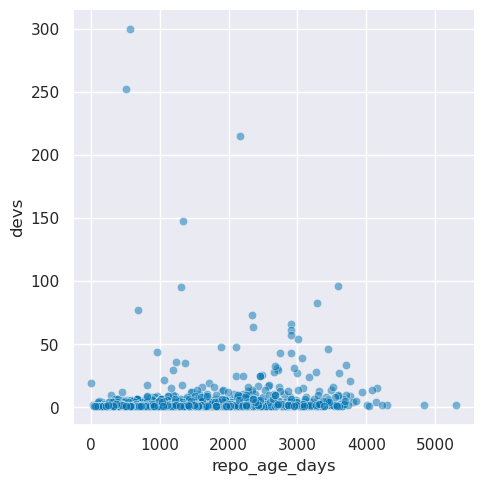

In [53]:
# plot setup  
(sns.set_theme(), 
 sns.set_palette('colorblind'),
 #plt.subplots(figsize=(8,8)),
 sns.relplot(
     data=total_stats_200s, x='repo_age_days', y='devs', alpha=0.5
 ), 
 #plt.xscale('log'),
 #plt.yscale('log') 
)

In [18]:
len(total_stats_200s[total_stats_200s['total_commits_last_year'] >= 1].index)
# 33 repos with more than 1 commit last year...

721

In [20]:
active_repos = total_stats_200s[total_stats_200s['total_commits_last_year'] >= 1]
print(active_repos)

                                    repo_name  initial_HTTP_code  \
1                ProyectoAether/Aether-Portal                200   
2                        MotionbyLearning/stm                200   
3     nicolasfara/reconfiguration-experiments                200   
4              ashleefv/CFDparticleLungMucosa                200   
8                         Nachida08/SnakeMAGs                200   
...                                       ...                ...   
1862                              FIDUCEO/MMS                200   
1864                      Potnislab/commensal                200   
1865                      vsquicciarini/madys                200   
1866        uwhackweek/hackweeks-as-a-service                200   
1873                    JacquesCarette/Drasil                200   

     issues_enabled  devs  total_commits_last_year has_PRs  \
1             False   5.0                     34.0    True   
2             False   6.0                    122.0    True 

(None, None, <seaborn.axisgrid.FacetGrid at 0x7f9917902e00>)

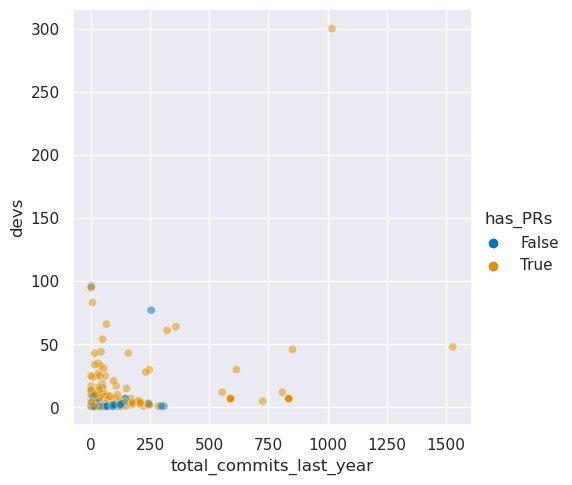

In [70]:
# plot setup  
(sns.set_theme(), 
 sns.set_palette('colorblind'),
 #plt.subplots(figsize=(8,8)),
 sns.relplot(
     data=active_repos, x='total_commits_last_year', y='devs', hue='has_PRs', alpha=0.5
 ), 
 #plt.xscale('log'),
 #plt.yscale('log') 
)

Text(0.5, 0.98, "Repos Active within Last Year: Total Commits in Last Year by Repo Age in Days (size ='N devs')")

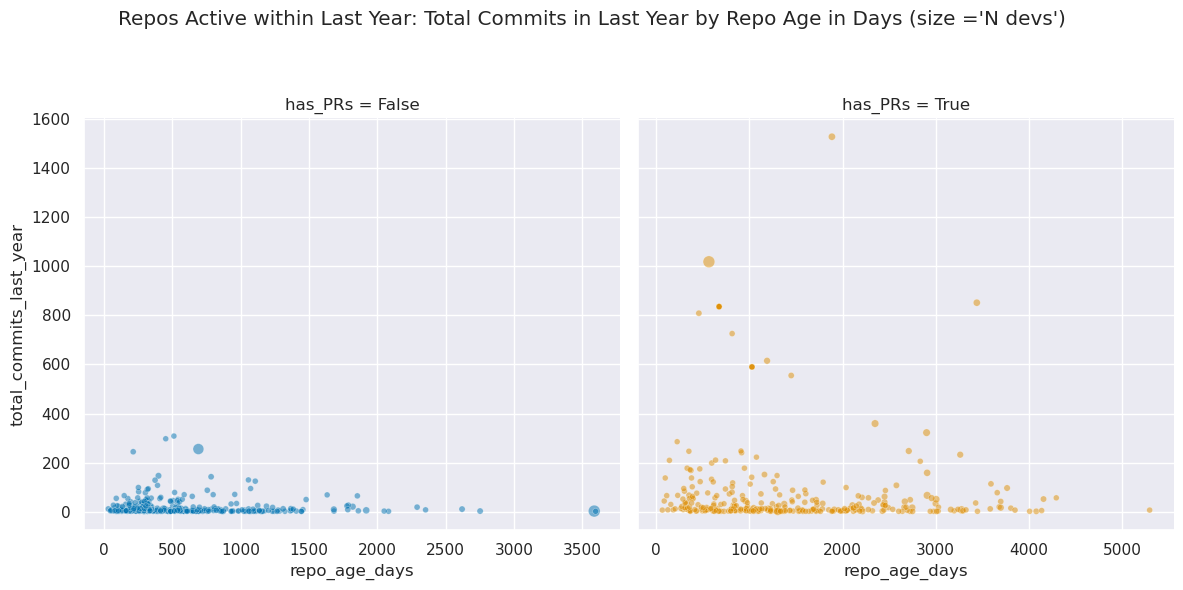

In [125]:
# plot setup  
sns.set_theme() 
sns.set_palette('colorblind')

g = sns.FacetGrid(active_repos, hue='has_PRs', col='has_PRs', margin_titles=True, height=6, sharey=True, sharex=False)
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("Repos Active within Last Year: Total Commits in Last Year by Repo Age in Days (size ='N devs')")

Text(0.5, 0.98, "Repos Active within Last Year: Total Commits in Last Year by Repo Age in Days (size ='N devs')")

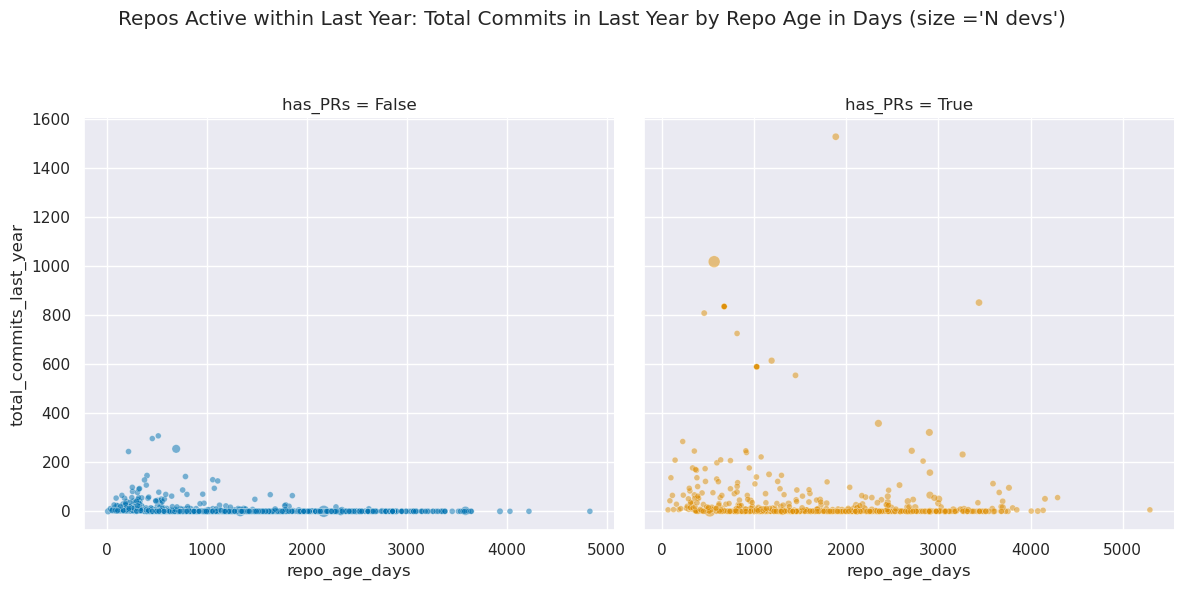

In [126]:
# plot setup  
sns.set_theme() 
sns.set_palette('colorblind')

g = sns.FacetGrid(total_stats_200s, hue='has_PRs', col='has_PRs', margin_titles=True, height=6, sharey=True, sharex=False)
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("All Repos: Total Commits in Last Year by Repo Age in Days (size ='N devs')")

# total commits last year vs dev count in active repos

(None, None, <seaborn.axisgrid.FacetGrid at 0x7f991e9db1c0>)

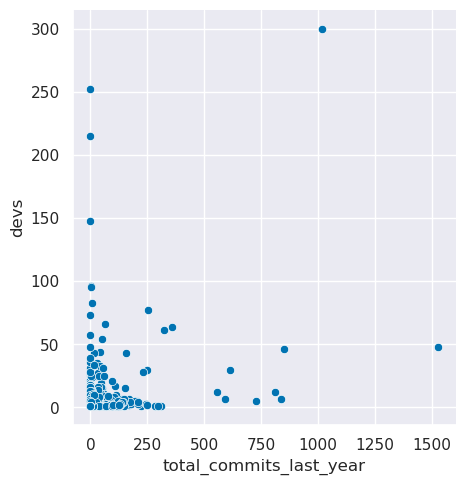

In [50]:
# plot setup  
(sns.set_theme(), 
 sns.set_palette('colorblind'),
 #plt.subplots(figsize=(8,8)),
 sns.relplot(
     data=total_stats_200s, x='total_commits_last_year', y='devs'
 ), 
 #plt.xscale('log'),
 #plt.yscale('log') 
)

# number of devs in active (commit in last year) repos

(None, None, <seaborn.axisgrid.FacetGrid at 0x7f991613a5c0>)

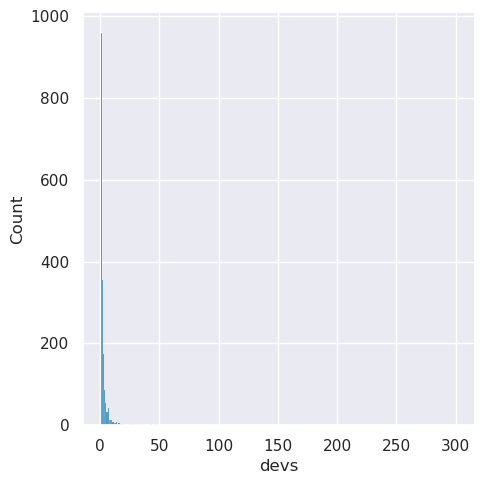

In [84]:
bins=[1, 2, 5, 10]


# plot setup  
(sns.set_theme(), 
 sns.set_palette('colorblind'),
 #plt.subplots(figsize=(8,8)),
 sns.displot(
     data=total_stats_200s, x='devs', discrete=True
 ), 
 #plt.xscale('log'),
 #plt.yscale('log') 
)

[Text(0, 0, '1823'), Text(0, 0, '53')]

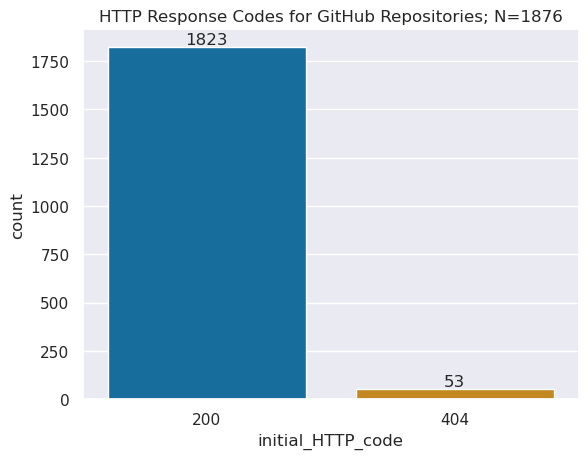

In [63]:
ax = sns.countplot(data=total_stats, x='initial_HTTP_code')
ax.set_title(f"HTTP Response Codes for GitHub Repositories; N={len(total_stats.index)}")
ax.bar_label(ax.containers[0])

### get stats for 1 repo  

In [4]:
#config_path = '../../githubanalysis/config.cfg'

In [5]:
logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/summarise_repo_stats_NOTEBOOK_logs.txt')  
repo_summariser = RepoStatsSummariser(logger)

In [4]:
gh_urls_df = pd.read_csv("../../data/todo_2024-02-06.csv", header=0, usecols=['ZenodoID', 'repo_name'], dtype={'ZenodoID':'Int64', 'repo_name':'str'})
gh_urls_df.shape

(1062, 2)

In [7]:
gh_urls_df_short = gh_urls_df[30:50]
print(gh_urls_df_short)

    ZenodoID                                          repo_name
30   4572578                               miker83z/testingIPFS
31   5213970                             andremano/sigap-public
32   6665561                 BaptisteLafoux/free_swim_illum_var
33   1421272                           anacost/neural-network-R
34   2645176                            terhardt/DO-progression
35   3557320                                yannabraham/cytofan
36   1044476                                     ebach/AMF_COBS
37   1000984            SandstoneHPC/sandstone-jupyterhub-login
38    259432                               mdhurst1/RoBoCoP_CRN
39   6344189                        uhh-lt/narrativity-frontend
40   1135281                 kimberscott/lookit-data-processing
41   6417753  wistful-zhang/TJNU-Large-Scale-Cloud-Detection...
42   3757860                              dosgillespie/hseclean
43   5338931            torsades-de-pointes/TAILOR_PCI_Bayesian
44   3258705                          gc

In [5]:
rec_collator = []
loop_num = 0

for repo in gh_urls_df_short.repo_name:
    loop_num += 1
    print(f">>> Getting data for repo {loop_num} of {len(gh_urls_df_short.index)}: {repo}")
    repo_stats = repo_summariser.summarise_repo_stats(repo_name=repo, config_path='../../githubanalysis/config.cfg', per_pg=1, verbose=True)
    rec_collator.append(repo_stats)
    
rec_df = pd.DataFrame(rec_collator)
print(rec_df)

NameError: name 'gh_urls_df_short' is not defined

In [7]:
logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/summarise_repo_stats_NOTEBOOK_B_logs.txt')  
repo_summariser = RepoStatsSummariser(logger)

gh_urls_df_short = gh_urls_df[60:80]
print(gh_urls_df_short)

rec_collator = []
loop_num = 0

for repo in gh_urls_df_short.repo_name:
    loop_num += 1
    print(f">>> Getting data for repo {loop_num} of {len(gh_urls_df_short.index)}: {repo} <<<")
    repo_stats = repo_summariser.summarise_repo_stats(repo_name=repo, config_path='../../githubanalysis/config.cfg', per_pg=1, verbose=True)
    rec_collator.append(repo_stats)
    
rec_df = pd.DataFrame(rec_collator)
print(rec_df)

2024-02-07 16:36:33,550 DEBUG Added a stderr logging handler to logger: urllib3
2024-02-07 16:36:33,553 DEBUG Starting new HTTPS connection (1): api.github.com:443


    ZenodoID                                          repo_name
60   6611707           rwsayaman/TCGA_PanCancer_Immune_Genetics
61   6491095                                   DCHamerslag/FACT
62   4783680                                 ltmurray/GCClassic
63   3518900                                    nickp60/sraFind
64   5520581                               lfabreti/convenience
65   5932968                  spatel093/Otoscopy-Simulator-Data
66   1321565                                  sennierer/spacyal
67   4422012                                  pearsonlab/improv
68   3339906                         kenkellner/mofep-synthesis
69      9825                                lmullen/slavery-map
70   4299990                     abrandberg/femIndentationModel
71   1436857                globalbioticinteractions/roopnarine
72   1346749                                     JensJauch/NRBA
73   5532663                           mnmahir/FYProject-PCGIPI
74   5854874                            

2024-02-07 16:36:33,833 DEBUG https://api.github.com:443 "GET /repos/rwsayaman/TCGA_PanCancer_Immune_Genetics HTTP/1.1" 200 None
INFO:API response at initial connection to rwsayaman/TCGA_PanCancer_Immune_Genetics for request https://api.github.com/repos/rwsayaman/TCGA_PanCancer_Immune_Genetics is <Response [200]>.


API response at initial connection to rwsayaman/TCGA_PanCancer_Immune_Genetics is <Response [200]>


2024-02-07 16:36:34,075 DEBUG https://api.github.com:443 "GET /repos/rwsayaman/TCGA_PanCancer_Immune_Genetics/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:36:34,077 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:36:34,376 DEBUG https://api.github.com:443 "GET /repos/rwsayaman/TCGA_PanCancer_Immune_Genetics/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:36:34,379 DEBUG Incremented Retry for (url='/repos/rwsayaman/TCGA_PanCancer_Immune_Genetics/stats/commit_activity'): Retry(total=9, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:36:34,379 DEBUG Retry: /repos/rwsayaman/TCGA_PanCancer_Immune_Genetics/stats/commit_activity
2024-02-07 16:36:34,601 DEBUG https://api.github.com:443 "GET /repos/rwsayaman/TCGA_PanCancer_Immune_Genetics/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:36:34,602 DEBUG Incremented Retry for (url='/repos/rwsayaman/TCGA_PanCancer_Immune_Genetics/stats/commit_activity'): Retry(total=8, connect=5, rea

>>> Getting data for repo 2 of 20: DCHamerslag/FACT <<<


2024-02-07 16:36:38,791 DEBUG https://api.github.com:443 "GET /repos/DCHamerslag/FACT HTTP/1.1" 200 None
2024-02-07 16:36:38,791 DEBUG https://api.github.com:443 "GET /repos/DCHamerslag/FACT HTTP/1.1" 200 None
INFO:API response at initial connection to DCHamerslag/FACT for request https://api.github.com/repos/DCHamerslag/FACT is <Response [200]>.


API response at initial connection to DCHamerslag/FACT is <Response [200]>


2024-02-07 16:36:39,016 DEBUG https://api.github.com:443 "GET /repos/DCHamerslag/FACT/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:36:39,016 DEBUG https://api.github.com:443 "GET /repos/DCHamerslag/FACT/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:36:39,020 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:36:39,020 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:36:39,320 DEBUG https://api.github.com:443 "GET /repos/DCHamerslag/FACT/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:36:39,320 DEBUG https://api.github.com:443 "GET /repos/DCHamerslag/FACT/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:36:39,321 DEBUG Incremented Retry for (url='/repos/DCHamerslag/FACT/stats/commit_activity'): Retry(total=9, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:36:39,321 DEBUG Incremented Retry for (url='/repos/DCHamerslag/FACT/stats/commit_activity'): Retry(total=9, connect=5, read=3, re

>>> Getting data for repo 3 of 20: ltmurray/GCClassic <<<


2024-02-07 16:37:02,159 DEBUG https://api.github.com:443 "GET /repos/ltmurray/GCClassic HTTP/1.1" 200 None
2024-02-07 16:37:02,159 DEBUG https://api.github.com:443 "GET /repos/ltmurray/GCClassic HTTP/1.1" 200 None
2024-02-07 16:37:02,159 DEBUG https://api.github.com:443 "GET /repos/ltmurray/GCClassic HTTP/1.1" 200 None
INFO:API response at initial connection to ltmurray/GCClassic for request https://api.github.com/repos/ltmurray/GCClassic is <Response [200]>.


API response at initial connection to ltmurray/GCClassic is <Response [200]>


2024-02-07 16:37:02,388 DEBUG https://api.github.com:443 "GET /repos/ltmurray/GCClassic/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:02,388 DEBUG https://api.github.com:443 "GET /repos/ltmurray/GCClassic/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:02,388 DEBUG https://api.github.com:443 "GET /repos/ltmurray/GCClassic/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:02,391 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:37:02,391 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:37:02,391 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:37:02,790 DEBUG https://api.github.com:443 "GET /repos/ltmurray/GCClassic/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:37:02,790 DEBUG https://api.github.com:443 "GET /repos/ltmurray/GCClassic/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:37:02,790 DEBUG https://api.github.com:443 "GET /repos/ltmurray/GCCl

>>> Getting data for repo 4 of 20: nickp60/sraFind <<<


2024-02-07 16:37:13,389 DEBUG https://api.github.com:443 "GET /repos/nickp60/sraFind HTTP/1.1" 200 None
2024-02-07 16:37:13,389 DEBUG https://api.github.com:443 "GET /repos/nickp60/sraFind HTTP/1.1" 200 None
2024-02-07 16:37:13,389 DEBUG https://api.github.com:443 "GET /repos/nickp60/sraFind HTTP/1.1" 200 None
2024-02-07 16:37:13,389 DEBUG https://api.github.com:443 "GET /repos/nickp60/sraFind HTTP/1.1" 200 None
INFO:API response at initial connection to nickp60/sraFind for request https://api.github.com/repos/nickp60/sraFind is <Response [200]>.


API response at initial connection to nickp60/sraFind is <Response [200]>


2024-02-07 16:37:13,632 DEBUG https://api.github.com:443 "GET /repos/nickp60/sraFind/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:13,632 DEBUG https://api.github.com:443 "GET /repos/nickp60/sraFind/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:13,632 DEBUG https://api.github.com:443 "GET /repos/nickp60/sraFind/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:13,632 DEBUG https://api.github.com:443 "GET /repos/nickp60/sraFind/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:13,636 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:37:13,636 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:37:13,636 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:37:13,636 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:37:13,909 DEBUG https://api.github.com:443 "GET /repos/nickp60/sraFind/stats/commit_activity HTTP/1.1" 202 2
2

2024-02-07 16:37:36,285 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:37:36,577 DEBUG https://api.github.com:443 "GET /repos/nickp60/sraFind HTTP/1.1" 200 None
2024-02-07 16:37:36,577 DEBUG https://api.github.com:443 "GET /repos/nickp60/sraFind HTTP/1.1" 200 None
2024-02-07 16:37:36,577 DEBUG https://api.github.com:443 "GET /repos/nickp60/sraFind HTTP/1.1" 200 None
2024-02-07 16:37:36,577 DEBUG https://api.github.com:443 "GET /repos/nickp60/sraFind HTTP/1.1" 200 None
2024-02-07 16:37:36,765 DEBUG https://api.github.com:443 "GET /repos/nickp60/sraFind/languages HTTP/1.1" 200 None
2024-02-07 16:37:36,765 DEBUG https://api.github.com:443 "GET /repos/nickp60/sraFind/languages HTTP/1.1" 200 None
2024-02-07 16:37:36,765 DEBUG https://api.github.com:443 "GET /repos/nickp60/sraFind/languages HTTP/1.1" 200 None
2024-02-07 16:37:36,765 DEBUG https://api.github.com:443 "GET /repos/nickp60/sraFind/languages HTTP/1.1" 200 None
INFO:Stats for nickp60/sraFind: {'repo_name'

>>> Getting data for repo 5 of 20: lfabreti/convenience <<<


2024-02-07 16:37:37,080 DEBUG https://api.github.com:443 "GET /repos/lfabreti/convenience HTTP/1.1" 200 None
2024-02-07 16:37:37,080 DEBUG https://api.github.com:443 "GET /repos/lfabreti/convenience HTTP/1.1" 200 None
2024-02-07 16:37:37,080 DEBUG https://api.github.com:443 "GET /repos/lfabreti/convenience HTTP/1.1" 200 None
2024-02-07 16:37:37,080 DEBUG https://api.github.com:443 "GET /repos/lfabreti/convenience HTTP/1.1" 200 None
2024-02-07 16:37:37,080 DEBUG https://api.github.com:443 "GET /repos/lfabreti/convenience HTTP/1.1" 200 None
INFO:API response at initial connection to lfabreti/convenience for request https://api.github.com/repos/lfabreti/convenience is <Response [200]>.


API response at initial connection to lfabreti/convenience is <Response [200]>


2024-02-07 16:37:37,296 DEBUG https://api.github.com:443 "GET /repos/lfabreti/convenience/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:37,296 DEBUG https://api.github.com:443 "GET /repos/lfabreti/convenience/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:37,296 DEBUG https://api.github.com:443 "GET /repos/lfabreti/convenience/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:37,296 DEBUG https://api.github.com:443 "GET /repos/lfabreti/convenience/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:37,296 DEBUG https://api.github.com:443 "GET /repos/lfabreti/convenience/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:37,301 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:37:37,301 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:37:37,301 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:37:37,301 DEBUG Starting new HTTPS

2024-02-07 16:37:41,774 DEBUG Added a stderr logging handler to logger: urllib3
2024-02-07 16:37:41,774 DEBUG Added a stderr logging handler to logger: urllib3
2024-02-07 16:37:41,774 DEBUG Added a stderr logging handler to logger: urllib3
2024-02-07 16:37:41,774 DEBUG Added a stderr logging handler to logger: urllib3
2024-02-07 16:37:41,774 DEBUG Added a stderr logging handler to logger: urllib3
2024-02-07 16:37:41,774 DEBUG Added a stderr logging handler to logger: urllib3
2024-02-07 16:37:41,779 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:37:41,779 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:37:41,779 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:37:41,779 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:37:41,779 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:37:41,779 DEBUG Starting new HTTPS connection (1): api.github.com:443


>>> Getting data for repo 6 of 20: spatel093/Otoscopy-Simulator-Data <<<


2024-02-07 16:37:42,108 DEBUG https://api.github.com:443 "GET /repos/spatel093/Otoscopy-Simulator-Data HTTP/1.1" 200 None
2024-02-07 16:37:42,108 DEBUG https://api.github.com:443 "GET /repos/spatel093/Otoscopy-Simulator-Data HTTP/1.1" 200 None
2024-02-07 16:37:42,108 DEBUG https://api.github.com:443 "GET /repos/spatel093/Otoscopy-Simulator-Data HTTP/1.1" 200 None
2024-02-07 16:37:42,108 DEBUG https://api.github.com:443 "GET /repos/spatel093/Otoscopy-Simulator-Data HTTP/1.1" 200 None
2024-02-07 16:37:42,108 DEBUG https://api.github.com:443 "GET /repos/spatel093/Otoscopy-Simulator-Data HTTP/1.1" 200 None
2024-02-07 16:37:42,108 DEBUG https://api.github.com:443 "GET /repos/spatel093/Otoscopy-Simulator-Data HTTP/1.1" 200 None
INFO:API response at initial connection to spatel093/Otoscopy-Simulator-Data for request https://api.github.com/repos/spatel093/Otoscopy-Simulator-Data is <Response [200]>.


API response at initial connection to spatel093/Otoscopy-Simulator-Data is <Response [200]>


2024-02-07 16:37:42,318 DEBUG https://api.github.com:443 "GET /repos/spatel093/Otoscopy-Simulator-Data/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:42,318 DEBUG https://api.github.com:443 "GET /repos/spatel093/Otoscopy-Simulator-Data/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:42,318 DEBUG https://api.github.com:443 "GET /repos/spatel093/Otoscopy-Simulator-Data/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:42,318 DEBUG https://api.github.com:443 "GET /repos/spatel093/Otoscopy-Simulator-Data/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:42,318 DEBUG https://api.github.com:443 "GET /repos/spatel093/Otoscopy-Simulator-Data/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:42,318 DEBUG https://api.github.com:443 "GET /repos/spatel093/Otoscopy-Simulator-Data/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:42,328 DEBUG Starting new HTTPS connection (1): api.github.com:44

2024-02-07 16:37:46,092 DEBUG Incremented Retry for (url='/repos/spatel093/Otoscopy-Simulator-Data/stats/commit_activity'): Retry(total=7, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:37:52,098 DEBUG Retry: /repos/spatel093/Otoscopy-Simulator-Data/stats/commit_activity
2024-02-07 16:37:52,098 DEBUG Retry: /repos/spatel093/Otoscopy-Simulator-Data/stats/commit_activity
2024-02-07 16:37:52,098 DEBUG Retry: /repos/spatel093/Otoscopy-Simulator-Data/stats/commit_activity
2024-02-07 16:37:52,098 DEBUG Retry: /repos/spatel093/Otoscopy-Simulator-Data/stats/commit_activity
2024-02-07 16:37:52,098 DEBUG Retry: /repos/spatel093/Otoscopy-Simulator-Data/stats/commit_activity
2024-02-07 16:37:52,098 DEBUG Retry: /repos/spatel093/Otoscopy-Simulator-Data/stats/commit_activity
2024-02-07 16:37:52,267 DEBUG https://api.github.com:443 "GET /repos/spatel093/Otoscopy-Simulator-Data/stats/commit_activity HTTP/1.1" 200 None
2024-02-07 16:37:52,267 DEBUG https://api.github.com:443 "GET /repos/s

>>> Getting data for repo 7 of 20: sennierer/spacyal <<<


2024-02-07 16:37:53,200 DEBUG https://api.github.com:443 "GET /repos/sennierer/spacyal HTTP/1.1" 200 None
2024-02-07 16:37:53,200 DEBUG https://api.github.com:443 "GET /repos/sennierer/spacyal HTTP/1.1" 200 None
2024-02-07 16:37:53,200 DEBUG https://api.github.com:443 "GET /repos/sennierer/spacyal HTTP/1.1" 200 None
2024-02-07 16:37:53,200 DEBUG https://api.github.com:443 "GET /repos/sennierer/spacyal HTTP/1.1" 200 None
2024-02-07 16:37:53,200 DEBUG https://api.github.com:443 "GET /repos/sennierer/spacyal HTTP/1.1" 200 None
2024-02-07 16:37:53,200 DEBUG https://api.github.com:443 "GET /repos/sennierer/spacyal HTTP/1.1" 200 None
2024-02-07 16:37:53,200 DEBUG https://api.github.com:443 "GET /repos/sennierer/spacyal HTTP/1.1" 200 None
INFO:API response at initial connection to sennierer/spacyal for request https://api.github.com/repos/sennierer/spacyal is <Response [200]>.


API response at initial connection to sennierer/spacyal is <Response [200]>


2024-02-07 16:37:53,411 DEBUG https://api.github.com:443 "GET /repos/sennierer/spacyal/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:53,411 DEBUG https://api.github.com:443 "GET /repos/sennierer/spacyal/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:53,411 DEBUG https://api.github.com:443 "GET /repos/sennierer/spacyal/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:53,411 DEBUG https://api.github.com:443 "GET /repos/sennierer/spacyal/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:53,411 DEBUG https://api.github.com:443 "GET /repos/sennierer/spacyal/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:53,411 DEBUG https://api.github.com:443 "GET /repos/sennierer/spacyal/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:53,411 DEBUG https://api.github.com:443 "GET /repos/sennierer/spacyal/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:53,418 DEBUG Starting ne

2024-02-07 16:37:57,490 DEBUG https://api.github.com:443 "GET /repos/sennierer/spacyal/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 None
2024-02-07 16:37:57,490 DEBUG https://api.github.com:443 "GET /repos/sennierer/spacyal/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 None
2024-02-07 16:37:57,490 DEBUG https://api.github.com:443 "GET /repos/sennierer/spacyal/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 None
2024-02-07 16:37:57,490 DEBUG https://api.github.com:443 "GET /repos/sennierer/spacyal/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 None
2024-02-07 16:37:57,554 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:37:57,554 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:37:57,554 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:37:57,554 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:37:57,554 DEBU

>>> Getting data for repo 8 of 20: pearsonlab/improv <<<


2024-02-07 16:37:58,289 DEBUG https://api.github.com:443 "GET /repos/pearsonlab/improv HTTP/1.1" 301 198
2024-02-07 16:37:58,289 DEBUG https://api.github.com:443 "GET /repos/pearsonlab/improv HTTP/1.1" 301 198
2024-02-07 16:37:58,289 DEBUG https://api.github.com:443 "GET /repos/pearsonlab/improv HTTP/1.1" 301 198
2024-02-07 16:37:58,289 DEBUG https://api.github.com:443 "GET /repos/pearsonlab/improv HTTP/1.1" 301 198
2024-02-07 16:37:58,289 DEBUG https://api.github.com:443 "GET /repos/pearsonlab/improv HTTP/1.1" 301 198
2024-02-07 16:37:58,289 DEBUG https://api.github.com:443 "GET /repos/pearsonlab/improv HTTP/1.1" 301 198
2024-02-07 16:37:58,289 DEBUG https://api.github.com:443 "GET /repos/pearsonlab/improv HTTP/1.1" 301 198
2024-02-07 16:37:58,289 DEBUG https://api.github.com:443 "GET /repos/pearsonlab/improv HTTP/1.1" 301 198
2024-02-07 16:37:58,542 DEBUG https://api.github.com:443 "GET /repositories/148823779 HTTP/1.1" 200 None
2024-02-07 16:37:58,542 DEBUG https://api.github.com:44

API response at initial connection to pearsonlab/improv is <Response [200]>


2024-02-07 16:37:59,004 DEBUG https://api.github.com:443 "GET /repositories/148823779/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:59,004 DEBUG https://api.github.com:443 "GET /repositories/148823779/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:59,004 DEBUG https://api.github.com:443 "GET /repositories/148823779/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:59,004 DEBUG https://api.github.com:443 "GET /repositories/148823779/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:59,004 DEBUG https://api.github.com:443 "GET /repositories/148823779/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:59,004 DEBUG https://api.github.com:443 "GET /repositories/148823779/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:59,004 DEBUG https://api.github.com:443 "GET /repositories/148823779/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:37:59,004 DEBUG https://api.github

2024-02-07 16:38:02,735 DEBUG Retry: /repositories/148823779/stats/commit_activity
2024-02-07 16:38:02,735 DEBUG Retry: /repositories/148823779/stats/commit_activity
2024-02-07 16:38:02,735 DEBUG Retry: /repositories/148823779/stats/commit_activity
2024-02-07 16:38:02,735 DEBUG Retry: /repositories/148823779/stats/commit_activity
2024-02-07 16:38:02,735 DEBUG Retry: /repositories/148823779/stats/commit_activity
2024-02-07 16:38:02,735 DEBUG Retry: /repositories/148823779/stats/commit_activity
2024-02-07 16:38:02,735 DEBUG Retry: /repositories/148823779/stats/commit_activity
2024-02-07 16:38:02,999 DEBUG https://api.github.com:443 "GET /repositories/148823779/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:38:02,999 DEBUG https://api.github.com:443 "GET /repositories/148823779/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:38:02,999 DEBUG https://api.github.com:443 "GET /repositories/148823779/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:38:02,999 DEBUG https://api.githu

2024-02-07 16:38:21,518 DEBUG Incremented Retry for (url='/repositories/148823779/stats/commit_activity'): Retry(total=5, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:38:21,518 DEBUG Incremented Retry for (url='/repositories/148823779/stats/commit_activity'): Retry(total=5, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:38:21,518 DEBUG Incremented Retry for (url='/repositories/148823779/stats/commit_activity'): Retry(total=5, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:38:21,518 DEBUG Incremented Retry for (url='/repositories/148823779/stats/commit_activity'): Retry(total=5, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:38:45,528 DEBUG Retry: /repositories/148823779/stats/commit_activity
2024-02-07 16:38:45,528 DEBUG Retry: /repositories/148823779/stats/commit_activity
2024-02-07 16:38:45,528 DEBUG Retry: /repositories/148823779/stats/commit_activity
2024-02-07 16:38:45,528 DEBUG Retry: /repositories/148823779/stats/commit_a

2024-02-07 16:38:47,267 DEBUG https://api.github.com:443 "GET /repositories/148823779/languages HTTP/1.1" 200 None
2024-02-07 16:38:47,267 DEBUG https://api.github.com:443 "GET /repositories/148823779/languages HTTP/1.1" 200 None
2024-02-07 16:38:47,267 DEBUG https://api.github.com:443 "GET /repositories/148823779/languages HTTP/1.1" 200 None
2024-02-07 16:38:47,267 DEBUG https://api.github.com:443 "GET /repositories/148823779/languages HTTP/1.1" 200 None
2024-02-07 16:38:47,267 DEBUG https://api.github.com:443 "GET /repositories/148823779/languages HTTP/1.1" 200 None
2024-02-07 16:38:47,267 DEBUG https://api.github.com:443 "GET /repositories/148823779/languages HTTP/1.1" 200 None
2024-02-07 16:38:47,267 DEBUG https://api.github.com:443 "GET /repositories/148823779/languages HTTP/1.1" 200 None
INFO:Stats for pearsonlab/improv: {'repo_name': 'pearsonlab/improv', 'issues_enabled': False, 'devs': 22, 'total_commits_last_year': 131, 'has_PRs': True, 'last_PR_update': datetime.datetime(2024

>>> Getting data for repo 9 of 20: kenkellner/mofep-synthesis <<<


2024-02-07 16:38:47,505 DEBUG https://api.github.com:443 "GET /repos/kenkellner/mofep-synthesis HTTP/1.1" 404 None
2024-02-07 16:38:47,505 DEBUG https://api.github.com:443 "GET /repos/kenkellner/mofep-synthesis HTTP/1.1" 404 None
2024-02-07 16:38:47,505 DEBUG https://api.github.com:443 "GET /repos/kenkellner/mofep-synthesis HTTP/1.1" 404 None
2024-02-07 16:38:47,505 DEBUG https://api.github.com:443 "GET /repos/kenkellner/mofep-synthesis HTTP/1.1" 404 None
2024-02-07 16:38:47,505 DEBUG https://api.github.com:443 "GET /repos/kenkellner/mofep-synthesis HTTP/1.1" 404 None
2024-02-07 16:38:47,505 DEBUG https://api.github.com:443 "GET /repos/kenkellner/mofep-synthesis HTTP/1.1" 404 None
2024-02-07 16:38:47,505 DEBUG https://api.github.com:443 "GET /repos/kenkellner/mofep-synthesis HTTP/1.1" 404 None
2024-02-07 16:38:47,505 DEBUG https://api.github.com:443 "GET /repos/kenkellner/mofep-synthesis HTTP/1.1" 404 None
2024-02-07 16:38:47,505 DEBUG https://api.github.com:443 "GET /repos/kenkellner/

API response at initial connection to kenkellner/mofep-synthesis is <Response [404]>


2024-02-07 16:38:47,916 DEBUG https://api.github.com:443 "GET /repos/kenkellner/mofep-synthesis/stats/commit_activity HTTP/1.1" 404 None
2024-02-07 16:38:47,916 DEBUG https://api.github.com:443 "GET /repos/kenkellner/mofep-synthesis/stats/commit_activity HTTP/1.1" 404 None
2024-02-07 16:38:47,916 DEBUG https://api.github.com:443 "GET /repos/kenkellner/mofep-synthesis/stats/commit_activity HTTP/1.1" 404 None
2024-02-07 16:38:47,916 DEBUG https://api.github.com:443 "GET /repos/kenkellner/mofep-synthesis/stats/commit_activity HTTP/1.1" 404 None
2024-02-07 16:38:47,916 DEBUG https://api.github.com:443 "GET /repos/kenkellner/mofep-synthesis/stats/commit_activity HTTP/1.1" 404 None
2024-02-07 16:38:47,916 DEBUG https://api.github.com:443 "GET /repos/kenkellner/mofep-synthesis/stats/commit_activity HTTP/1.1" 404 None
2024-02-07 16:38:47,916 DEBUG https://api.github.com:443 "GET /repos/kenkellner/mofep-synthesis/stats/commit_activity HTTP/1.1" 404 None
2024-02-07 16:38:47,916 DEBUG https://api

2024-02-07 16:38:48,530 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:38:48,530 DEBUG Starting new HTTPS connection (1): api.github.com:443


>>> Getting data for repo 10 of 20: lmullen/slavery-map <<<


2024-02-07 16:38:48,809 DEBUG https://api.github.com:443 "GET /repos/lmullen/slavery-map HTTP/1.1" 200 None
2024-02-07 16:38:48,809 DEBUG https://api.github.com:443 "GET /repos/lmullen/slavery-map HTTP/1.1" 200 None
2024-02-07 16:38:48,809 DEBUG https://api.github.com:443 "GET /repos/lmullen/slavery-map HTTP/1.1" 200 None
2024-02-07 16:38:48,809 DEBUG https://api.github.com:443 "GET /repos/lmullen/slavery-map HTTP/1.1" 200 None
2024-02-07 16:38:48,809 DEBUG https://api.github.com:443 "GET /repos/lmullen/slavery-map HTTP/1.1" 200 None
2024-02-07 16:38:48,809 DEBUG https://api.github.com:443 "GET /repos/lmullen/slavery-map HTTP/1.1" 200 None
2024-02-07 16:38:48,809 DEBUG https://api.github.com:443 "GET /repos/lmullen/slavery-map HTTP/1.1" 200 None
2024-02-07 16:38:48,809 DEBUG https://api.github.com:443 "GET /repos/lmullen/slavery-map HTTP/1.1" 200 None
2024-02-07 16:38:48,809 DEBUG https://api.github.com:443 "GET /repos/lmullen/slavery-map HTTP/1.1" 200 None
2024-02-07 16:38:48,809 DEBU

API response at initial connection to lmullen/slavery-map is <Response [200]>


2024-02-07 16:38:49,025 DEBUG https://api.github.com:443 "GET /repos/lmullen/slavery-map/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:38:49,025 DEBUG https://api.github.com:443 "GET /repos/lmullen/slavery-map/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:38:49,025 DEBUG https://api.github.com:443 "GET /repos/lmullen/slavery-map/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:38:49,025 DEBUG https://api.github.com:443 "GET /repos/lmullen/slavery-map/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:38:49,025 DEBUG https://api.github.com:443 "GET /repos/lmullen/slavery-map/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:38:49,025 DEBUG https://api.github.com:443 "GET /repos/lmullen/slavery-map/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:38:49,025 DEBUG https://api.github.com:443 "GET /repos/lmullen/slavery-map/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:38:49,025 DEB

2024-02-07 16:38:49,578 DEBUG Incremented Retry for (url='/repos/lmullen/slavery-map/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:38:49,578 DEBUG Incremented Retry for (url='/repos/lmullen/slavery-map/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:38:49,578 DEBUG Incremented Retry for (url='/repos/lmullen/slavery-map/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:38:49,578 DEBUG Incremented Retry for (url='/repos/lmullen/slavery-map/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:38:49,578 DEBUG Incremented Retry for (url='/repos/lmullen/slavery-map/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:38:52,586 DEBUG Retry: /repos/lmullen/slavery-map/stats/commit_activity
2024-02-07 16:38:52,586 DEBUG Retry: /repos/lmullen/sl

2024-02-07 16:38:59,184 DEBUG https://api.github.com:443 "GET /repos/lmullen/slavery-map/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 2
2024-02-07 16:38:59,192 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:38:59,192 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:38:59,192 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:38:59,192 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:38:59,192 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:38:59,192 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:38:59,192 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:38:59,192 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:38:59,192 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:38:59,192 DEBUG Starting new HTTPS connection (1): api.github.com:443
20

>>> Getting data for repo 11 of 20: abrandberg/femIndentationModel <<<


2024-02-07 16:38:59,921 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel HTTP/1.1" 200 None
2024-02-07 16:38:59,921 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel HTTP/1.1" 200 None
2024-02-07 16:38:59,921 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel HTTP/1.1" 200 None
2024-02-07 16:38:59,921 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel HTTP/1.1" 200 None
2024-02-07 16:38:59,921 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel HTTP/1.1" 200 None
2024-02-07 16:38:59,921 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel HTTP/1.1" 200 None
2024-02-07 16:38:59,921 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel HTTP/1.1" 200 None
2024-02-07 16:38:59,921 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel HTTP/1.1" 200 None
2024-02-07 16:38:59,921 DEBUG https://api.github

API response at initial connection to abrandberg/femIndentationModel is <Response [200]>


2024-02-07 16:39:00,143 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:00,143 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:00,143 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:00,143 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:00,143 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:00,143 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:00,143 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel/

2024-02-07 16:39:00,658 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:39:00,658 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:39:00,658 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:39:00,665 DEBUG Incremented Retry for (url='/repos/abrandberg/femIndentationModel/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:39:00,665 DEBUG Incremented Retry for (url='/repos/abrandberg/femIndentationModel/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:39:00,665 DEBUG Incremented Retry for (url='/repos/abrandberg/femIndentationModel/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:39:00,665 DEBUG Increme

2024-02-07 16:39:04,310 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel HTTP/1.1" 200 None
2024-02-07 16:39:04,310 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel HTTP/1.1" 200 None
2024-02-07 16:39:04,310 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel HTTP/1.1" 200 None
2024-02-07 16:39:04,310 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel HTTP/1.1" 200 None
2024-02-07 16:39:04,310 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel HTTP/1.1" 200 None
2024-02-07 16:39:04,310 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel HTTP/1.1" 200 None
2024-02-07 16:39:04,310 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel HTTP/1.1" 200 None
2024-02-07 16:39:04,494 DEBUG https://api.github.com:443 "GET /repos/abrandberg/femIndentationModel/languages HTTP/1.1" 200 16
2024-02-07 16:39:04,494 DEBUG https://ap

>>> Getting data for repo 12 of 20: globalbioticinteractions/roopnarine <<<


2024-02-07 16:39:04,880 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine HTTP/1.1" 200 None
2024-02-07 16:39:04,880 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine HTTP/1.1" 200 None
2024-02-07 16:39:04,880 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine HTTP/1.1" 200 None
2024-02-07 16:39:04,880 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine HTTP/1.1" 200 None
2024-02-07 16:39:04,880 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine HTTP/1.1" 200 None
2024-02-07 16:39:04,880 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine HTTP/1.1" 200 None
2024-02-07 16:39:04,880 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine HTTP/1.1" 200 None
2024-02-07 16:39:04,880 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine HTTP/1.1" 200 None
2024-02-

API response at initial connection to globalbioticinteractions/roopnarine is <Response [200]>


2024-02-07 16:39:05,100 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:05,100 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:05,100 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:05,100 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:05,100 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:05,100 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:05,100 DEBUG https://api.github.com:443 "GET /repos/g

2024-02-07 16:39:05,669 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:39:05,669 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:39:05,669 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:39:05,669 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:39:05,669 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:39:05,669 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:39:05,669 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine/stats/commit_activity HTTP/1.1" 202 2

2024-02-07 16:39:08,893 DEBUG Incremented Retry for (url='/repos/globalbioticinteractions/roopnarine/stats/commit_activity'): Retry(total=7, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:39:08,893 DEBUG Incremented Retry for (url='/repos/globalbioticinteractions/roopnarine/stats/commit_activity'): Retry(total=7, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:39:08,893 DEBUG Incremented Retry for (url='/repos/globalbioticinteractions/roopnarine/stats/commit_activity'): Retry(total=7, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:39:08,893 DEBUG Incremented Retry for (url='/repos/globalbioticinteractions/roopnarine/stats/commit_activity'): Retry(total=7, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:39:14,905 DEBUG Retry: /repos/globalbioticinteractions/roopnarine/stats/commit_activity
2024-02-07 16:39:14,905 DEBUG Retry: /repos/globalbioticinteractions/roopnarine/stats/commit_activity
2024-02-07 16:39:14,905 DEBUG Retry: /repos/

2024-02-07 16:39:15,887 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine/languages HTTP/1.1" 200 2
2024-02-07 16:39:15,887 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine/languages HTTP/1.1" 200 2
2024-02-07 16:39:15,887 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine/languages HTTP/1.1" 200 2
2024-02-07 16:39:15,887 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine/languages HTTP/1.1" 200 2
2024-02-07 16:39:15,887 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine/languages HTTP/1.1" 200 2
2024-02-07 16:39:15,887 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine/languages HTTP/1.1" 200 2
2024-02-07 16:39:15,887 DEBUG https://api.github.com:443 "GET /repos/globalbioticinteractions/roopnarine/languages HTTP/1.1" 200 2
2024-02-07 16:39:15,887 DEBUG https://api.github.com:443 "GET /repos/globalbioticin

>>> Getting data for repo 13 of 20: JensJauch/NRBA <<<


2024-02-07 16:39:16,287 DEBUG https://api.github.com:443 "GET /repos/JensJauch/NRBA HTTP/1.1" 200 None
2024-02-07 16:39:16,287 DEBUG https://api.github.com:443 "GET /repos/JensJauch/NRBA HTTP/1.1" 200 None
2024-02-07 16:39:16,287 DEBUG https://api.github.com:443 "GET /repos/JensJauch/NRBA HTTP/1.1" 200 None
2024-02-07 16:39:16,287 DEBUG https://api.github.com:443 "GET /repos/JensJauch/NRBA HTTP/1.1" 200 None
2024-02-07 16:39:16,287 DEBUG https://api.github.com:443 "GET /repos/JensJauch/NRBA HTTP/1.1" 200 None
2024-02-07 16:39:16,287 DEBUG https://api.github.com:443 "GET /repos/JensJauch/NRBA HTTP/1.1" 200 None
2024-02-07 16:39:16,287 DEBUG https://api.github.com:443 "GET /repos/JensJauch/NRBA HTTP/1.1" 200 None
2024-02-07 16:39:16,287 DEBUG https://api.github.com:443 "GET /repos/JensJauch/NRBA HTTP/1.1" 200 None
2024-02-07 16:39:16,287 DEBUG https://api.github.com:443 "GET /repos/JensJauch/NRBA HTTP/1.1" 200 None
2024-02-07 16:39:16,287 DEBUG https://api.github.com:443 "GET /repos/Jens

API response at initial connection to JensJauch/NRBA is <Response [200]>


2024-02-07 16:39:16,498 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:16,498 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:16,498 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:16,498 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:16,498 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:16,498 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:16,498 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:16,498 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:16,498 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:16,498 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:16,498 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:16,498 DEBUG Starting new HTTPS connection (1): api.github.

2024-02-07 16:39:17,071 DEBUG Incremented Retry for (url='/repos/JensJauch/NRBA/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:39:17,071 DEBUG Incremented Retry for (url='/repos/JensJauch/NRBA/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:39:17,071 DEBUG Incremented Retry for (url='/repos/JensJauch/NRBA/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:39:17,071 DEBUG Incremented Retry for (url='/repos/JensJauch/NRBA/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:39:17,071 DEBUG Incremented Retry for (url='/repos/JensJauch/NRBA/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:39:17,071 DEBUG Incremented Retry for (url='/repos/JensJauch/NRBA/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None

2024-02-07 16:39:26,487 DEBUG https://api.github.com:443 "GET /repos/JensJauch/NRBA/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:39:26,487 DEBUG https://api.github.com:443 "GET /repos/JensJauch/NRBA/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:39:26,487 DEBUG https://api.github.com:443 "GET /repos/JensJauch/NRBA/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:39:26,487 DEBUG https://api.github.com:443 "GET /repos/JensJauch/NRBA/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:39:26,493 DEBUG Incremented Retry for (url='/repos/JensJauch/NRBA/stats/commit_activity'): Retry(total=6, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:39:26,493 DEBUG Incremented Retry for (url='/repos/JensJauch/NRBA/stats/commit_activity'): Retry(total=6, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:39:26,493 DEBUG Incremented Retry for (url='/repos/JensJauch/NRBA/stats/commit_activity'): Retry(total=6, connect=5, read=3, redirect=None, status=None)
2024-02-07 

2024-02-07 16:39:38,922 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:38,922 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:39,238 DEBUG https://api.github.com:443 "GET /repos/JensJauch/NRBA HTTP/1.1" 200 None
2024-02-07 16:39:39,238 DEBUG https://api.github.com:443 "GET /repos/JensJauch/NRBA HTTP/1.1" 200 None
2024-02-07 16:39:39,238 DEBUG https://api.github.com:443 "GET /repos/JensJauch/NRBA HTTP/1.1" 200 None
2024-02-07 16:39:39,238 DEBUG https://api.github.com:443 "GET /repos/JensJauch/NRBA HTTP/1.1" 200 None
2024-02-07 16:39:39,238 DEBUG https://api.github.com:443 "GET /repos/JensJauch/NRBA HTTP/1.1" 200 None
2024-02-07 16:39:39,238 DEBUG https://api.github.com:443 "GET /repos/JensJauch/NRBA HTTP/1.1" 200 None
2024-02-07 16:39:39,238 DEBUG https://api.github.com:443 "GET /repos/JensJauch/NRBA HTTP/1.1" 200 None
2024-02-07 16:39:39,238 DEBUG https://api.github.com:443 "GET /repos/JensJauch/NRBA HTTP/1.1" 200 None
2024-02-

>>> Getting data for repo 14 of 20: mnmahir/FYProject-PCGIPI <<<


2024-02-07 16:39:39,750 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI HTTP/1.1" 200 None
2024-02-07 16:39:39,750 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI HTTP/1.1" 200 None
2024-02-07 16:39:39,750 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI HTTP/1.1" 200 None
2024-02-07 16:39:39,750 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI HTTP/1.1" 200 None
2024-02-07 16:39:39,750 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI HTTP/1.1" 200 None
2024-02-07 16:39:39,750 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI HTTP/1.1" 200 None
2024-02-07 16:39:39,750 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI HTTP/1.1" 200 None
2024-02-07 16:39:39,750 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI HTTP/1.1" 200 None
2024-02-07 16:39:39,750 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI HT

API response at initial connection to mnmahir/FYProject-PCGIPI is <Response [200]>


2024-02-07 16:39:39,973 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:39,973 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:39,973 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:39,973 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:39,973 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:39,973 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:39,973 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI/contributors?per_page=1&anon=1 HTTP/1.1" 2

2024-02-07 16:39:40,313 DEBUG Retry: /repos/mnmahir/FYProject-PCGIPI/stats/commit_activity
2024-02-07 16:39:40,313 DEBUG Retry: /repos/mnmahir/FYProject-PCGIPI/stats/commit_activity
2024-02-07 16:39:40,313 DEBUG Retry: /repos/mnmahir/FYProject-PCGIPI/stats/commit_activity
2024-02-07 16:39:40,313 DEBUG Retry: /repos/mnmahir/FYProject-PCGIPI/stats/commit_activity
2024-02-07 16:39:40,313 DEBUG Retry: /repos/mnmahir/FYProject-PCGIPI/stats/commit_activity
2024-02-07 16:39:40,313 DEBUG Retry: /repos/mnmahir/FYProject-PCGIPI/stats/commit_activity
2024-02-07 16:39:40,543 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:39:40,543 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:39:40,543 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:39:40,543 DEBUG https://api.github.com:443 "

2024-02-07 16:39:44,125 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 None
2024-02-07 16:39:44,125 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 None
2024-02-07 16:39:44,125 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 None
2024-02-07 16:39:44,125 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 None
2024-02-07 16:39:44,125 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 None
2024-02-07 16:39:44,125 DEBUG https://api.github.com:443 "GET /repos/mnmahir/FYProject-PCGIPI/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 None
2024

2024-02-07 16:39:44,616 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:44,616 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:44,616 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:44,616 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:44,616 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:44,616 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:44,616 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:44,616 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:44,616 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:44,616 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:44,616 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:39:44,616 DEBUG Starting new HTTPS connection (1): api.github.

>>> Getting data for repo 15 of 20: sjpierce/SSACHR <<<


2024-02-07 16:39:44,894 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR HTTP/1.1" 200 None
2024-02-07 16:39:44,894 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR HTTP/1.1" 200 None
2024-02-07 16:39:44,894 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR HTTP/1.1" 200 None
2024-02-07 16:39:44,894 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR HTTP/1.1" 200 None
2024-02-07 16:39:44,894 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR HTTP/1.1" 200 None
2024-02-07 16:39:44,894 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR HTTP/1.1" 200 None
2024-02-07 16:39:44,894 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR HTTP/1.1" 200 None
2024-02-07 16:39:44,894 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR HTTP/1.1" 200 None
2024-02-07 16:39:44,894 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR HTTP/1.1" 200 None
2024-02-07 16:39:44,894 DEBUG https://api.github.com:443 "GET /r

API response at initial connection to sjpierce/SSACHR is <Response [200]>


2024-02-07 16:39:45,115 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:45,115 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:45,115 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:45,115 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:45,115 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:45,115 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:45,115 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:39:45,115 DEBUG https://api.github.com:44

2024-02-07 16:39:45,441 DEBUG Retry: /repos/sjpierce/SSACHR/stats/commit_activity
2024-02-07 16:39:45,441 DEBUG Retry: /repos/sjpierce/SSACHR/stats/commit_activity
2024-02-07 16:39:45,441 DEBUG Retry: /repos/sjpierce/SSACHR/stats/commit_activity
2024-02-07 16:39:45,441 DEBUG Retry: /repos/sjpierce/SSACHR/stats/commit_activity
2024-02-07 16:39:45,441 DEBUG Retry: /repos/sjpierce/SSACHR/stats/commit_activity
2024-02-07 16:39:45,441 DEBUG Retry: /repos/sjpierce/SSACHR/stats/commit_activity
2024-02-07 16:39:45,441 DEBUG Retry: /repos/sjpierce/SSACHR/stats/commit_activity
2024-02-07 16:39:45,441 DEBUG Retry: /repos/sjpierce/SSACHR/stats/commit_activity
2024-02-07 16:39:45,641 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:39:45,641 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:39:45,641 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR/stats/commit_

2024-02-07 16:39:48,873 DEBUG Incremented Retry for (url='/repos/sjpierce/SSACHR/stats/commit_activity'): Retry(total=7, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:39:48,873 DEBUG Incremented Retry for (url='/repos/sjpierce/SSACHR/stats/commit_activity'): Retry(total=7, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:39:48,873 DEBUG Incremented Retry for (url='/repos/sjpierce/SSACHR/stats/commit_activity'): Retry(total=7, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:39:48,873 DEBUG Incremented Retry for (url='/repos/sjpierce/SSACHR/stats/commit_activity'): Retry(total=7, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:39:48,873 DEBUG Incremented Retry for (url='/repos/sjpierce/SSACHR/stats/commit_activity'): Retry(total=7, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:39:48,873 DEBUG Incremented Retry for (url='/repos/sjpierce/SSACHR/stats/commit_activity'): Retry(total=7, connect=5, read=3, redirect=None, statu

2024-02-07 16:40:07,118 DEBUG Retry: /repos/sjpierce/SSACHR/stats/commit_activity
2024-02-07 16:40:07,118 DEBUG Retry: /repos/sjpierce/SSACHR/stats/commit_activity
2024-02-07 16:40:07,118 DEBUG Retry: /repos/sjpierce/SSACHR/stats/commit_activity
2024-02-07 16:40:07,118 DEBUG Retry: /repos/sjpierce/SSACHR/stats/commit_activity
2024-02-07 16:40:07,118 DEBUG Retry: /repos/sjpierce/SSACHR/stats/commit_activity
2024-02-07 16:40:07,118 DEBUG Retry: /repos/sjpierce/SSACHR/stats/commit_activity
2024-02-07 16:40:07,118 DEBUG Retry: /repos/sjpierce/SSACHR/stats/commit_activity
2024-02-07 16:40:07,118 DEBUG Retry: /repos/sjpierce/SSACHR/stats/commit_activity
2024-02-07 16:40:07,118 DEBUG Retry: /repos/sjpierce/SSACHR/stats/commit_activity
2024-02-07 16:40:07,118 DEBUG Retry: /repos/sjpierce/SSACHR/stats/commit_activity
2024-02-07 16:40:07,118 DEBUG Retry: /repos/sjpierce/SSACHR/stats/commit_activity
2024-02-07 16:40:07,118 DEBUG Retry: /repos/sjpierce/SSACHR/stats/commit_activity
2024-02-07 16:40

2024-02-07 16:40:31,602 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:40:31,612 DEBUG Incremented Retry for (url='/repos/sjpierce/SSACHR/stats/commit_activity'): Retry(total=4, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:40:31,612 DEBUG Incremented Retry for (url='/repos/sjpierce/SSACHR/stats/commit_activity'): Retry(total=4, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:40:31,612 DEBUG Incremented Retry for (url='/repos/sjpierce/SSACHR/stats/commit_activity'): Retry(total=4, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:40:31,612 DEBUG Incremented Retry for (url='/repos/sjpierce/SSACHR/stats/commit_activity'): Retry(total=4, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:40:31,612 DEBUG Incremented Retry for (url='/repos/sjpierce/SSACHR/stats/commit_activity'): Retry(total=4, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:40:31,612 DEBUG Increme

2024-02-07 16:41:20,103 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 2
2024-02-07 16:41:20,103 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 2
2024-02-07 16:41:20,103 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 2
2024-02-07 16:41:20,103 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 2
2024-02-07 16:41:20,103 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 2
2024-02-07 16:41:20,103 DEBUG https://api.github.com:443 "GET /repos/sjpierce/SSACHR/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 2
2024-02-07 16:41:20,115 DEBUG Starting new HTTPS connection (1): api.github.

2024-02-07 16:41:20,610 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:41:20,610 DEBUG Starting new HTTPS connection (1): api.github.com:443


>>> Getting data for repo 16 of 20: cheechai/hello-world-complete-math- <<<


2024-02-07 16:41:20,841 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math- HTTP/1.1" 404 None
2024-02-07 16:41:20,841 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math- HTTP/1.1" 404 None
2024-02-07 16:41:20,841 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math- HTTP/1.1" 404 None
2024-02-07 16:41:20,841 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math- HTTP/1.1" 404 None
2024-02-07 16:41:20,841 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math- HTTP/1.1" 404 None
2024-02-07 16:41:20,841 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math- HTTP/1.1" 404 None
2024-02-07 16:41:20,841 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math- HTTP/1.1" 404 None
2024-02-07 16:41:20,841 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math- HTTP/1.1" 404 None
2024-02-

API response at initial connection to cheechai/hello-world-complete-math- is <Response [404]>


2024-02-07 16:41:21,273 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math-/stats/commit_activity HTTP/1.1" 404 None
2024-02-07 16:41:21,273 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math-/stats/commit_activity HTTP/1.1" 404 None
2024-02-07 16:41:21,273 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math-/stats/commit_activity HTTP/1.1" 404 None
2024-02-07 16:41:21,273 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math-/stats/commit_activity HTTP/1.1" 404 None
2024-02-07 16:41:21,273 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math-/stats/commit_activity HTTP/1.1" 404 None
2024-02-07 16:41:21,273 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math-/stats/commit_activity HTTP/1.1" 404 None
2024-02-07 16:41:21,273 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math-/stats/commit_activi

2024-02-07 16:41:21,888 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math- HTTP/1.1" 404 None
2024-02-07 16:41:21,888 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math- HTTP/1.1" 404 None
2024-02-07 16:41:21,888 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math- HTTP/1.1" 404 None
2024-02-07 16:41:21,888 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math- HTTP/1.1" 404 None
2024-02-07 16:41:21,888 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math- HTTP/1.1" 404 None
2024-02-07 16:41:21,888 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math- HTTP/1.1" 404 None
2024-02-07 16:41:21,888 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math- HTTP/1.1" 404 None
2024-02-07 16:41:21,888 DEBUG https://api.github.com:443 "GET /repos/cheechai/hello-world-complete-math- HTTP/1.1" 404 None
ERROR:Er

>>> Getting data for repo 17 of 20: jleute/colorednoise <<<


2024-02-07 16:41:22,597 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise HTTP/1.1" 200 None
2024-02-07 16:41:22,597 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise HTTP/1.1" 200 None
2024-02-07 16:41:22,597 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise HTTP/1.1" 200 None
2024-02-07 16:41:22,597 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise HTTP/1.1" 200 None
2024-02-07 16:41:22,597 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise HTTP/1.1" 200 None
2024-02-07 16:41:22,597 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise HTTP/1.1" 200 None
2024-02-07 16:41:22,597 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise HTTP/1.1" 200 None
2024-02-07 16:41:22,597 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise HTTP/1.1" 200 None
2024-02-07 16:41:22,597 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise HTTP/1.1" 200 None
2024-02-07 16:41:22,597 DEBU

API response at initial connection to jleute/colorednoise is <Response [200]>


2024-02-07 16:41:22,848 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:22,848 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:22,848 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:22,848 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:22,848 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:22,848 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:22,848 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:22,848 DEB

2024-02-07 16:41:23,150 DEBUG Incremented Retry for (url='/repos/jleute/colorednoise/stats/commit_activity'): Retry(total=9, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:23,150 DEBUG Incremented Retry for (url='/repos/jleute/colorednoise/stats/commit_activity'): Retry(total=9, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:23,150 DEBUG Incremented Retry for (url='/repos/jleute/colorednoise/stats/commit_activity'): Retry(total=9, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:23,160 DEBUG Retry: /repos/jleute/colorednoise/stats/commit_activity
2024-02-07 16:41:23,160 DEBUG Retry: /repos/jleute/colorednoise/stats/commit_activity
2024-02-07 16:41:23,160 DEBUG Retry: /repos/jleute/colorednoise/stats/commit_activity
2024-02-07 16:41:23,160 DEBUG Retry: /repos/jleute/colorednoise/stats/commit_activity
2024-02-07 16:41:23,160 DEBUG Retry: /repos/jleute/colorednoise/stats/commit_activity
2024-02-07 16:41:23,160 DEBUG Retry: /repos/jleute/col

2024-02-07 16:41:23,660 DEBUG Starting new HTTPS connection (1): api.github.com:443
2024-02-07 16:41:23,968 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise HTTP/1.1" 200 None
2024-02-07 16:41:23,968 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise HTTP/1.1" 200 None
2024-02-07 16:41:23,968 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise HTTP/1.1" 200 None
2024-02-07 16:41:23,968 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise HTTP/1.1" 200 None
2024-02-07 16:41:23,968 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise HTTP/1.1" 200 None
2024-02-07 16:41:23,968 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise HTTP/1.1" 200 None
2024-02-07 16:41:23,968 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise HTTP/1.1" 200 None
2024-02-07 16:41:23,968 DEBUG https://api.github.com:443 "GET /repos/jleute/colorednoise HTTP/1.1" 200 None
2024-02-07 16:41:23,968 DEBUG https://api.github.com

>>> Getting data for repo 18 of 20: nikostourvas/optimal_sampling <<<


2024-02-07 16:41:24,505 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling HTTP/1.1" 200 None
2024-02-07 16:41:24,505 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling HTTP/1.1" 200 None
2024-02-07 16:41:24,505 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling HTTP/1.1" 200 None
2024-02-07 16:41:24,505 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling HTTP/1.1" 200 None
2024-02-07 16:41:24,505 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling HTTP/1.1" 200 None
2024-02-07 16:41:24,505 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling HTTP/1.1" 200 None
2024-02-07 16:41:24,505 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling HTTP/1.1" 200 None
2024-02-07 16:41:24,505 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling HTTP/1.1" 200 None
2024-02-07 16:41:24,505 DEBUG https://api.github.com:443

API response at initial connection to nikostourvas/optimal_sampling is <Response [200]>


2024-02-07 16:41:24,746 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:24,746 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:24,746 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:24,746 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:24,746 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:24,746 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:24,746 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling/contrib

2024-02-07 16:41:25,074 DEBUG Incremented Retry for (url='/repos/nikostourvas/optimal_sampling/stats/commit_activity'): Retry(total=9, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:25,074 DEBUG Incremented Retry for (url='/repos/nikostourvas/optimal_sampling/stats/commit_activity'): Retry(total=9, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:25,074 DEBUG Incremented Retry for (url='/repos/nikostourvas/optimal_sampling/stats/commit_activity'): Retry(total=9, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:25,074 DEBUG Incremented Retry for (url='/repos/nikostourvas/optimal_sampling/stats/commit_activity'): Retry(total=9, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:25,074 DEBUG Incremented Retry for (url='/repos/nikostourvas/optimal_sampling/stats/commit_activity'): Retry(total=9, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:25,074 DEBUG Incremented Retry for (url='/repos/nikostourvas/optimal_samp

2024-02-07 16:41:25,318 DEBUG Incremented Retry for (url='/repos/nikostourvas/optimal_sampling/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:25,318 DEBUG Incremented Retry for (url='/repos/nikostourvas/optimal_sampling/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:25,318 DEBUG Incremented Retry for (url='/repos/nikostourvas/optimal_sampling/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:25,318 DEBUG Incremented Retry for (url='/repos/nikostourvas/optimal_sampling/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:25,318 DEBUG Incremented Retry for (url='/repos/nikostourvas/optimal_sampling/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:28,332 DEBUG Retry: /repos/nikostourvas/optimal_sampling/stats/commit_act

2024-02-07 16:41:28,546 DEBUG Incremented Retry for (url='/repos/nikostourvas/optimal_sampling/stats/commit_activity'): Retry(total=7, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:34,563 DEBUG Retry: /repos/nikostourvas/optimal_sampling/stats/commit_activity
2024-02-07 16:41:34,563 DEBUG Retry: /repos/nikostourvas/optimal_sampling/stats/commit_activity
2024-02-07 16:41:34,563 DEBUG Retry: /repos/nikostourvas/optimal_sampling/stats/commit_activity
2024-02-07 16:41:34,563 DEBUG Retry: /repos/nikostourvas/optimal_sampling/stats/commit_activity
2024-02-07 16:41:34,563 DEBUG Retry: /repos/nikostourvas/optimal_sampling/stats/commit_activity
2024-02-07 16:41:34,563 DEBUG Retry: /repos/nikostourvas/optimal_sampling/stats/commit_activity
2024-02-07 16:41:34,563 DEBUG Retry: /repos/nikostourvas/optimal_sampling/stats/commit_activity
2024-02-07 16:41:34,563 DEBUG Retry: /repos/nikostourvas/optimal_sampling/stats/commit_activity
2024-02-07 16:41:34,563 DEBUG Retry: /repos/nikost

2024-02-07 16:41:46,797 DEBUG Retry: /repos/nikostourvas/optimal_sampling/stats/commit_activity
2024-02-07 16:41:46,797 DEBUG Retry: /repos/nikostourvas/optimal_sampling/stats/commit_activity
2024-02-07 16:41:46,797 DEBUG Retry: /repos/nikostourvas/optimal_sampling/stats/commit_activity
2024-02-07 16:41:46,797 DEBUG Retry: /repos/nikostourvas/optimal_sampling/stats/commit_activity
2024-02-07 16:41:46,797 DEBUG Retry: /repos/nikostourvas/optimal_sampling/stats/commit_activity
2024-02-07 16:41:46,797 DEBUG Retry: /repos/nikostourvas/optimal_sampling/stats/commit_activity
2024-02-07 16:41:46,797 DEBUG Retry: /repos/nikostourvas/optimal_sampling/stats/commit_activity
2024-02-07 16:41:46,797 DEBUG Retry: /repos/nikostourvas/optimal_sampling/stats/commit_activity
2024-02-07 16:41:46,797 DEBUG Retry: /repos/nikostourvas/optimal_sampling/stats/commit_activity
2024-02-07 16:41:46,797 DEBUG Retry: /repos/nikostourvas/optimal_sampling/stats/commit_activity
2024-02-07 16:41:46,797 DEBUG Retry: /re

2024-02-07 16:41:47,653 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling HTTP/1.1" 200 None
2024-02-07 16:41:47,653 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling HTTP/1.1" 200 None
2024-02-07 16:41:47,653 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling HTTP/1.1" 200 None
2024-02-07 16:41:47,653 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling HTTP/1.1" 200 None
2024-02-07 16:41:47,653 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling HTTP/1.1" 200 None
2024-02-07 16:41:47,653 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling HTTP/1.1" 200 None
2024-02-07 16:41:47,653 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling HTTP/1.1" 200 None
2024-02-07 16:41:47,653 DEBUG https://api.github.com:443 "GET /repos/nikostourvas/optimal_sampling HTTP/1.1" 200 None
2024-02-07 16:41:47,653 DEBUG https://api.github.com:443

>>> Getting data for repo 19 of 20: edwbaker/AquaticInsectLightTrap <<<


2024-02-07 16:41:48,156 DEBUG https://api.github.com:443 "GET /repos/edwbaker/AquaticInsectLightTrap HTTP/1.1" 200 None
2024-02-07 16:41:48,156 DEBUG https://api.github.com:443 "GET /repos/edwbaker/AquaticInsectLightTrap HTTP/1.1" 200 None
2024-02-07 16:41:48,156 DEBUG https://api.github.com:443 "GET /repos/edwbaker/AquaticInsectLightTrap HTTP/1.1" 200 None
2024-02-07 16:41:48,156 DEBUG https://api.github.com:443 "GET /repos/edwbaker/AquaticInsectLightTrap HTTP/1.1" 200 None
2024-02-07 16:41:48,156 DEBUG https://api.github.com:443 "GET /repos/edwbaker/AquaticInsectLightTrap HTTP/1.1" 200 None
2024-02-07 16:41:48,156 DEBUG https://api.github.com:443 "GET /repos/edwbaker/AquaticInsectLightTrap HTTP/1.1" 200 None
2024-02-07 16:41:48,156 DEBUG https://api.github.com:443 "GET /repos/edwbaker/AquaticInsectLightTrap HTTP/1.1" 200 None
2024-02-07 16:41:48,156 DEBUG https://api.github.com:443 "GET /repos/edwbaker/AquaticInsectLightTrap HTTP/1.1" 200 None
2024-02-07 16:41:48,156 DEBUG https://ap

API response at initial connection to edwbaker/AquaticInsectLightTrap is <Response [200]>


2024-02-07 16:41:48,385 DEBUG https://api.github.com:443 "GET /repos/edwbaker/AquaticInsectLightTrap/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:48,385 DEBUG https://api.github.com:443 "GET /repos/edwbaker/AquaticInsectLightTrap/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:48,385 DEBUG https://api.github.com:443 "GET /repos/edwbaker/AquaticInsectLightTrap/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:48,385 DEBUG https://api.github.com:443 "GET /repos/edwbaker/AquaticInsectLightTrap/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:48,385 DEBUG https://api.github.com:443 "GET /repos/edwbaker/AquaticInsectLightTrap/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:48,385 DEBUG https://api.github.com:443 "GET /repos/edwbaker/AquaticInsectLightTrap/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:48,385 DEBUG https://api.github.com:443 "GET /repos/edwbaker/AquaticInsectLig

2024-02-07 16:41:48,688 DEBUG Incremented Retry for (url='/repos/edwbaker/AquaticInsectLightTrap/stats/commit_activity'): Retry(total=9, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:48,688 DEBUG Incremented Retry for (url='/repos/edwbaker/AquaticInsectLightTrap/stats/commit_activity'): Retry(total=9, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:48,688 DEBUG Incremented Retry for (url='/repos/edwbaker/AquaticInsectLightTrap/stats/commit_activity'): Retry(total=9, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:48,688 DEBUG Incremented Retry for (url='/repos/edwbaker/AquaticInsectLightTrap/stats/commit_activity'): Retry(total=9, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:48,688 DEBUG Incremented Retry for (url='/repos/edwbaker/AquaticInsectLightTrap/stats/commit_activity'): Retry(total=9, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:48,688 DEBUG Incremented Retry for (url='/repos/edwbaker/Aquati

2024-02-07 16:41:48,927 DEBUG Incremented Retry for (url='/repos/edwbaker/AquaticInsectLightTrap/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:48,927 DEBUG Incremented Retry for (url='/repos/edwbaker/AquaticInsectLightTrap/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:48,927 DEBUG Incremented Retry for (url='/repos/edwbaker/AquaticInsectLightTrap/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:48,927 DEBUG Incremented Retry for (url='/repos/edwbaker/AquaticInsectLightTrap/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:48,927 DEBUG Incremented Retry for (url='/repos/edwbaker/AquaticInsectLightTrap/stats/commit_activity'): Retry(total=8, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:48,927 DEBUG Incremented Retry for (url='/repos/edwbaker/Aquati

2024-02-07 16:41:52,342 DEBUG https://api.github.com:443 "GET /repos/edwbaker/AquaticInsectLightTrap/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 2
2024-02-07 16:41:52,342 DEBUG https://api.github.com:443 "GET /repos/edwbaker/AquaticInsectLightTrap/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 2
2024-02-07 16:41:52,342 DEBUG https://api.github.com:443 "GET /repos/edwbaker/AquaticInsectLightTrap/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 2
2024-02-07 16:41:52,342 DEBUG https://api.github.com:443 "GET /repos/edwbaker/AquaticInsectLightTrap/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 2
2024-02-07 16:41:52,342 DEBUG https://api.github.com:443 "GET /repos/edwbaker/AquaticInsectLightTrap/pulls?per_pg=1&state=all&sort=updated&direction=desc HTTP/1.1" 200 2
2024-02-07 16:41:52,342 DEBUG https://api.github.com:443 "GET /repos/edwbaker/AquaticInsectLightTrap/pulls?per_pg=1&state=all&sort=updated&direction=d

2024-02-07 16:41:52,904 DEBUG Added a stderr logging handler to logger: urllib3
2024-02-07 16:41:52,904 DEBUG Added a stderr logging handler to logger: urllib3
2024-02-07 16:41:52,904 DEBUG Added a stderr logging handler to logger: urllib3
2024-02-07 16:41:52,904 DEBUG Added a stderr logging handler to logger: urllib3
2024-02-07 16:41:52,904 DEBUG Added a stderr logging handler to logger: urllib3
2024-02-07 16:41:52,904 DEBUG Added a stderr logging handler to logger: urllib3
2024-02-07 16:41:52,904 DEBUG Added a stderr logging handler to logger: urllib3
2024-02-07 16:41:52,904 DEBUG Added a stderr logging handler to logger: urllib3
2024-02-07 16:41:52,904 DEBUG Added a stderr logging handler to logger: urllib3
2024-02-07 16:41:52,904 DEBUG Added a stderr logging handler to logger: urllib3
2024-02-07 16:41:52,904 DEBUG Added a stderr logging handler to logger: urllib3
2024-02-07 16:41:52,904 DEBUG Added a stderr logging handler to logger: urllib3
2024-02-07 16:41:52,904 DEBUG Added a st

>>> Getting data for repo 20 of 20: fil123/LGS---lithogeostatistical-processig-method <<<


2024-02-07 16:41:53,310 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method HTTP/1.1" 200 None
2024-02-07 16:41:53,310 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method HTTP/1.1" 200 None
2024-02-07 16:41:53,310 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method HTTP/1.1" 200 None
2024-02-07 16:41:53,310 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method HTTP/1.1" 200 None
2024-02-07 16:41:53,310 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method HTTP/1.1" 200 None
2024-02-07 16:41:53,310 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method HTTP/1.1" 200 None
2024-02-07 16:41:53,310 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method HTTP/1.1" 200 None
2024-02-07 16:41:53,310 DEBUG http

API response at initial connection to fil123/LGS---lithogeostatistical-processig-method is <Response [200]>


2024-02-07 16:41:53,579 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:53,579 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:53,579 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:53,579 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:53,579 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method/contributors?per_page=1&anon=1 HTTP/1.1" 200 None
2024-02-07 16:41:53,579 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method/contributors?per_page=1&anon=1 HTTP/

2024-02-07 16:41:53,923 DEBUG Incremented Retry for (url='/repos/fil123/LGS---lithogeostatistical-processig-method/stats/commit_activity'): Retry(total=9, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:53,923 DEBUG Incremented Retry for (url='/repos/fil123/LGS---lithogeostatistical-processig-method/stats/commit_activity'): Retry(total=9, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:53,923 DEBUG Incremented Retry for (url='/repos/fil123/LGS---lithogeostatistical-processig-method/stats/commit_activity'): Retry(total=9, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:53,923 DEBUG Incremented Retry for (url='/repos/fil123/LGS---lithogeostatistical-processig-method/stats/commit_activity'): Retry(total=9, connect=5, read=3, redirect=None, status=None)
2024-02-07 16:41:53,923 DEBUG Incremented Retry for (url='/repos/fil123/LGS---lithogeostatistical-processig-method/stats/commit_activity'): Retry(total=9, connect=5, read=3, redirect=None, sta

2024-02-07 16:41:54,146 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:41:54,146 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:41:54,146 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:41:54,146 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:41:54,146 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:41:54,146 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method/stats/commit_activity HTTP/1.1" 202 2
2024-02-07 16:41:54,146 DEBUG https://api.github.com:443 "

2024-02-07 16:41:57,358 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method/stats/commit_activity HTTP/1.1" 200 None
2024-02-07 16:41:57,358 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method/stats/commit_activity HTTP/1.1" 200 None
2024-02-07 16:41:57,358 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method/stats/commit_activity HTTP/1.1" 200 None
2024-02-07 16:41:57,358 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method/stats/commit_activity HTTP/1.1" 200 None
2024-02-07 16:41:57,358 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method/stats/commit_activity HTTP/1.1" 200 None
2024-02-07 16:41:57,358 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method/stats/commit_activity HTTP/1.1" 200 None
2024-02-07 16:41:57,358 DEBUG https://ap

2024-02-07 16:41:57,853 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method HTTP/1.1" 200 None
2024-02-07 16:41:57,853 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method HTTP/1.1" 200 None
2024-02-07 16:41:57,853 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method HTTP/1.1" 200 None
2024-02-07 16:41:57,853 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method HTTP/1.1" 200 None
2024-02-07 16:41:57,853 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method HTTP/1.1" 200 None
2024-02-07 16:41:57,853 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method HTTP/1.1" 200 None
2024-02-07 16:41:57,853 DEBUG https://api.github.com:443 "GET /repos/fil123/LGS---lithogeostatistical-processig-method HTTP/1.1" 200 None
2024-02-07 16:41:57,853 DEBUG http

                                            repo_name  issues_enabled  devs  \
0            rwsayaman/TCGA_PanCancer_Immune_Genetics           False     2   
1                                    DCHamerslag/FACT           False     3   
2                                  ltmurray/GCClassic           False     6   
3                                     nickp60/sraFind           False     1   
4                                lfabreti/convenience           False     4   
5                   spatel093/Otoscopy-Simulator-Data           False     1   
6                                   sennierer/spacyal           False     1   
7                                   pearsonlab/improv           False    22   
8                          kenkellner/mofep-synthesis           False     1   
9                                 lmullen/slavery-map           False     1   
10                     abrandberg/femIndentationModel           False     2   
11                globalbioticinteractions/roopnarin

In [ ]:
logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/summarise_repo_stats_NOTEBOOK_B_logs.txt')  
repo_summariser = RepoStatsSummariser(logger)

gh_urls_df_ton = gh_urls_df[0:100]
#print(gh_urls_df_ton)

rec_collator = []
loop_num = 0

for repo in gh_urls_df_ton.repo_name:
    loop_num += 1
    print(f">>> Getting data for repo {loop_num} of {len(gh_urls_df_short.index)}: {repo} <<<")
    logger.info(f">>> Getting data for repo {loop_num} of {len(gh_urls_df_short.index)}: {repo} <<<")
    repo_stats = repo_summariser.summarise_repo_stats(repo_name=repo, config_path='../../githubanalysis/config.cfg', per_pg=1, verbose=True)
    rec_collator.append(repo_stats)
    
rec_df = pd.DataFrame(rec_collator)
print(rec_df)